<a href="https://colab.research.google.com/github/gj0210/CMP7239/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Initial Dataset Head ---
  session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001                  599           TCP               4   
1  SID_00002                  472           TCP               3   
2  SID_00003                  629           TCP               3   
3  SID_00004                  804           UDP               4   
4  SID_00005                  453           TCP               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             DES             0.606818              1   
1       1557.996461             DES             0.301569              0   
2         75.044262             DES             0.739164              2   
3        601.248835             DES             0.123267              0   
4        532.540888             AES             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         Edge                    0                1  
1      

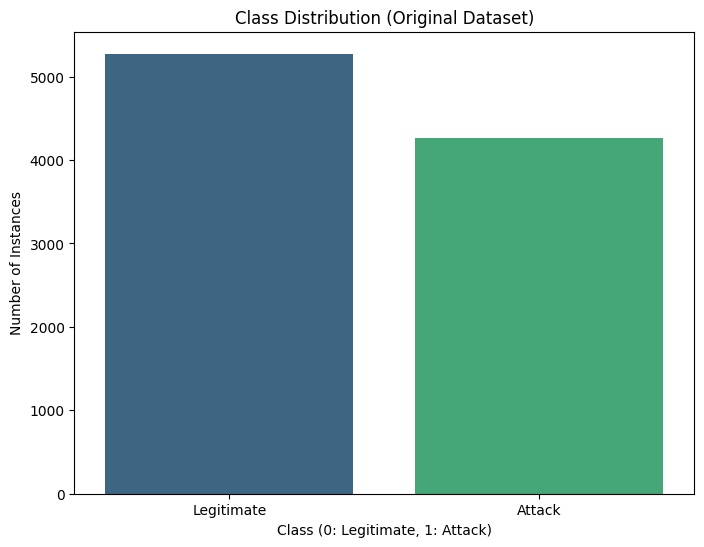


'class_distribution.png' saved to the current directory.

--- Applying SMOTE to Training Data ---
Original training set size: 7629
SMOTE-resampled training set size: 8436
SMOTE-resampled class distribution:
attack_detected
0    4218
1    4218
Name: count, dtype: int64

--- Training SVM Model ---

--- Training KNN Model ---

--- Training Decision Tree Model ---

             Final Model Performance Summary

--- Performance Metrics Table ---
               Precision    Recall  F1-Score
Algorithm                                   
SVM             0.959153  0.743259  0.837517
KNN             0.817808  0.699883  0.754264
Decision Tree   1.000000  0.740914  0.851178

--- Computational Efficiency Table ---
               Training Time (s)  Prediction Time (ms)
Algorithm                                             
SVM                    11.823237            421.472311
KNN                     0.015946            133.871794
Decision Tree           0.019403              2.051592


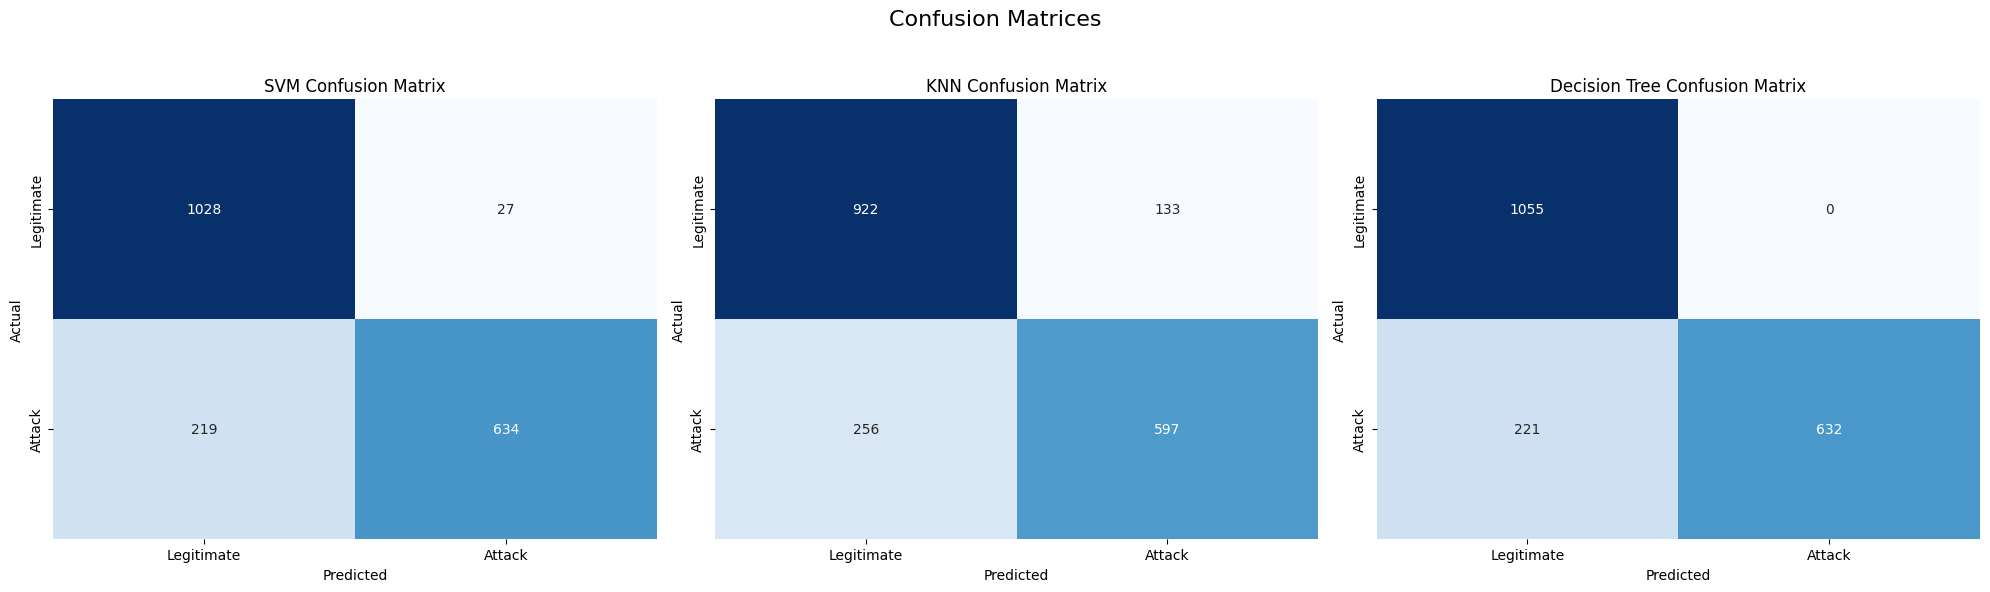


'confusion_matrices.png' saved to the current directory.


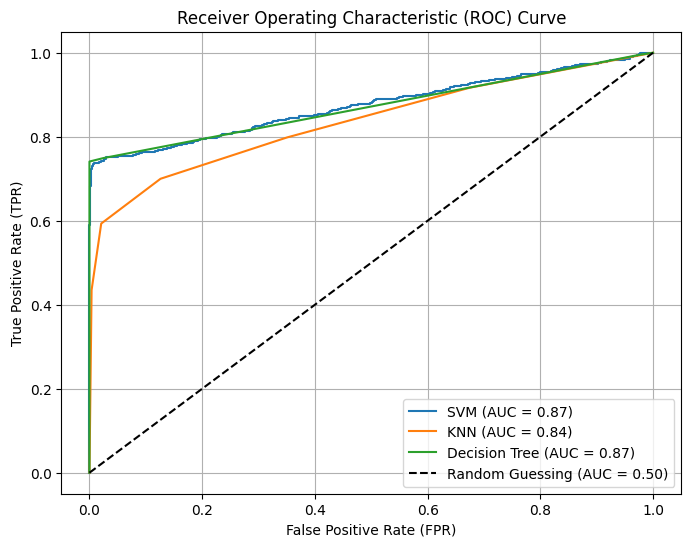


'roc_curves.png' saved to the current directory.

     Results to Insert into Canvas Document Placeholders

--- SVM Results ---
Precision: 0.9592
Recall: 0.7433
F1-Score: 0.8375
TP: 634
FP: 27
TN: 1028
FN: 219
Training Time (s): 11.8232
Prediction Time (ms): 421.4723

--- KNN Results ---
Precision: 0.8178
Recall: 0.6999
F1-Score: 0.7543
TP: 597
FP: 133
TN: 922
FN: 256
Training Time (s): 0.0159
Prediction Time (ms): 133.8718

--- Decision Tree Results ---
Precision: 1.0000
Recall: 0.7409
F1-Score: 0.8512
TP: 632
FP: 0
TN: 1055
FN: 221
Training Time (s): 0.0194
Prediction Time (ms): 2.0516


In [4]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Load and Prepare the Dataset ---
# ==============================================================================

# Load the dataset from the uploaded CSV file
df = None  # Initialize df to None
try:
    df = pd.read_csv('Cybersecurity Intrusion Detection(3).csv')
except FileNotFoundError:
    print("Error: The file 'Cybersecurity Intrusion Detection(3).csv' was not found.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


# Check if the dataframe was loaded successfully
if df is None:
    print("Data loading failed. Please ensure the file exists and the path is correct.")
else:
    # Print the first few rows to understand the data structure
    print("--- Initial Dataset Head ---")
    print(df.head())
    print("\n--- Dataset Info ---")
    print(df.info())

    # Drop the 'session_id' column as it's not useful for modeling
    df.drop('session_id', axis=1, inplace=True)

    # Separate features (X) and target variable (y)
    X = df.drop('attack_detected', axis=1)
    y = df['attack_detected']

    # ==============================================================================
    # --- Exploratory Data Analysis (EDA) - Class Distribution ---
    # ==============================================================================

    print("\n--- Class Distribution Before SMOTE ---")
    print(y.value_counts())

    # Visualize the class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y, palette='viridis')
    plt.title('Class Distribution (Original Dataset)')
    plt.xlabel('Class (0: Legitimate, 1: Attack)')
    plt.ylabel('Number of Instances')
    plt.xticks([0, 1], ['Legitimate', 'Attack'])
    plt.savefig('class_distribution.png')
    plt.show()
    print("\n'class_distribution.png' saved to the current directory.")

    # ==============================================================================
    # --- Preprocessing Pipeline ---
    # ==============================================================================

    # Identify numerical and categorical features
    numerical_features = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']
    categorical_features = ['protocol_type', 'encryption_used', 'browser_type', 'unusual_time_access']

    # One-hot encode the categorical features
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply StandardScaler to the numerical features
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

    # Handle class imbalance in the training data using SMOTE
    print("\n--- Applying SMOTE to Training Data ---")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print(f"Original training set size: {len(y_train)}")
    print(f"SMOTE-resampled training set size: {len(y_train_smote)}")
    print(f"SMOTE-resampled class distribution:\n{y_train_smote.value_counts()}")

    # ==============================================================================
    # --- Model Implementation and Training ---
    # ==============================================================================

    # Dictionary to hold the models and their configurations
    models = {
        'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform'),
        'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\n--- Training {name} Model ---")
        start_time = time.time()
        model.fit(X_train_smote, y_train_smote)
        training_time = time.time() - start_time

        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = (time.time() - start_time) * 1000 # Convert to milliseconds

        # Store results
        results[name] = {
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Training Time (s)': training_time,
            'Prediction Time (ms)': prediction_time
        }

    # ==============================================================================
    # --- Results and Evaluation ---
    # ==============================================================================

    print("\n" + "="*50)
    print("             Final Model Performance Summary")
    print("="*50)

    # Print performance metrics table
    print("\n--- Performance Metrics Table ---")
    performance_table = pd.DataFrame({
        'Algorithm': models.keys(),
        'Precision': [results[name]['Precision'] for name in models],
        'Recall': [results[name]['Recall'] for name in models],
        'F1-Score': [results[name]['F1-Score'] for name in models]
    }).set_index('Algorithm')
    print(performance_table)

    # Print computational efficiency table
    print("\n--- Computational Efficiency Table ---")
    efficiency_table = pd.DataFrame({
        'Algorithm': models.keys(),
        'Training Time (s)': [results[name]['Training Time (s)'] for name in models],
        'Prediction Time (ms)': [results[name]['Prediction Time (ms)'] for name in models]
    }).set_index('Algorithm')
    print(efficiency_table)

    # Plot Confusion Matrices as heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Confusion Matrices', fontsize=16)

    for i, (name, res) in enumerate(results.items()):
        cm = res['Confusion Matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['Legitimate', 'Attack'])
        axes[i].set_yticklabels(['Legitimate', 'Attack'])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('confusion_matrices.png')
    plt.show()
    print("\n'confusion_matrices.png' saved to the current directory.")

    # Plot ROC-AUC curves
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        elif name == 'SVM': # SVC with probability=True
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('roc_curves.png')
    plt.show()
    print("\n'roc_curves.png' saved to the current directory.")

    # ==============================================================================
    # --- Print Results for Placeholder Insertion ---
    # ==============================================================================

    print("\n" + "="*50)
    print("     Results to Insert into Canvas Document Placeholders")
    print("="*50)
    for name, res in results.items():
        print(f"\n--- {name} Results ---")
        print(f"Precision: {res['Precision']:.4f}")
        print(f"Recall: {res['Recall']:.4f}")
        print(f"F1-Score: {res['F1-Score']:.4f}")
        print(f"TP: {res['Confusion Matrix'][1, 1]}")
        print(f"FP: {res['Confusion Matrix'][0, 1]}")
        print(f"TN: {res['Confusion Matrix'][0, 0]}")
        print(f"FN: {res['Confusion Matrix'][1, 0]}")
        print(f"Training Time (s): {res['Training Time (s)']:.4f}")
        print(f"Prediction Time (ms): {res['Prediction Time (ms)']:.4f}")